In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy

# Generating data

In [2]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [3]:
y=(X[:,0]**2 + X[:,1]**2)**.5 < 60

In [4]:
X,X_test,y,y_test = train_test_split(X,y)

In [5]:
X.shape,X_test.shape

((1875, 2), (625, 2))

In [6]:
def PlotData(X,y):
    plt.scatter(x=X[:,0],y=X[:,1],c=y)    

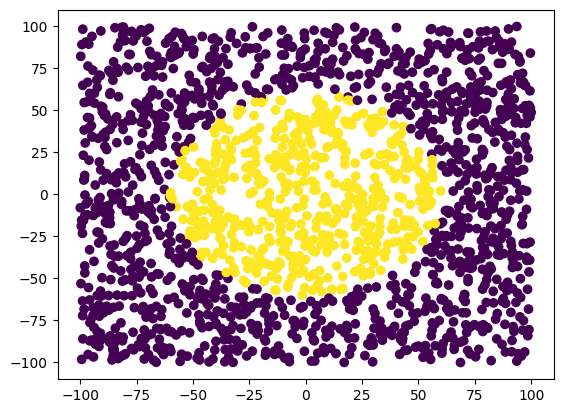

In [7]:
PlotData(X,y)

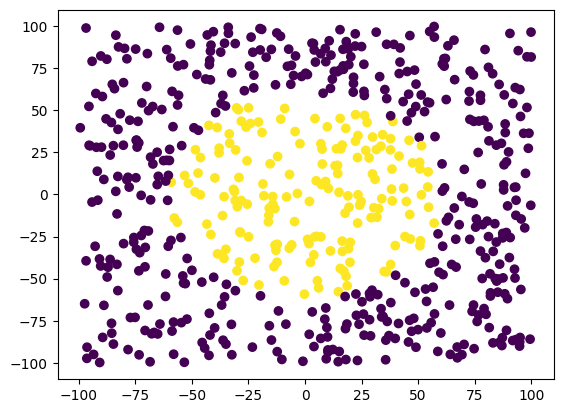

In [8]:
PlotData(X_test,y_test)

# Activations

In [9]:
class Sigmoid:
    def __init__(self):
        self.In = None
        self.H = lambda X : 1/(1+numpy.exp(-X))
    def forward(self,X):
        self.In = X.copy()
        self.out = self.H(X)
        return self.out
    def backward(self,y):
        inv_sigmoid = lambda y : numpy.log(x/(1-x))
        return (self.H(self.In)*(1-self.H(self.In))).dot(X)     
class ReLU:
    def __init__(self):
        

# Loss

In [59]:
class LogLoss:
    def __init__(self):
        ...
    def eval(self,y,y_pred):
        self.out =  -(y*numpy.log(y_pred)+(1-y)*numpy.log(1-y_pred)).mean()
        return self.out
    def Grad(self,X,y,y_pred):
        return X.T.dot(y_pred-y)/X.shape[0]
        

In [60]:
X = numpy.array([[1,2],[3,4],[5,6]])
y_pred = numpy.array([[.9],[.6],[.2]])
y= numpy.array([[1],[0],[1]])

In [61]:
y_pred - ((y == numpy.unique(y))+0)

array([[ 0.9, -0.1],
       [-0.4,  0.6],
       [ 0.2, -0.8]])

In [62]:
c=LogLoss()
c.eval(y,y_pred)

0.8770297199886938

In [63]:
c.Grad(X,y,y_pred)

array([[-0.76666667],
       [-0.86666667]])

# Layer

In [29]:
inv_sigmoid(numpy.array([0.1,0.30,0.4]))

array([-2.19722458, -0.84729786, -0.40546511])

In [30]:
1/(1+numpy.exp(-inv_sigmoid(numpy.array([0.1,0.30,0.4]))))

array([0.1, 0.3, 0.4])

In [64]:
class Layer:
    def __init__(self,n_in,n_out):
        self.n_in = n_in
        self.n_out = n_out
        self.ws = [numpy.zeros((n_in+1,1))]*n_out
        self.H = lambda w : numpy.c_[numpy.ones((self.X.shape[0],1)),self.X].dot(w)
    def backward(self,Δ):
            self.ws -= Δw       
    def forward(self,X):
        self.X = X
        self.out = numpy.array([*map(self.H,self.ws)])  
        return self.out    

# Architechture

In [65]:
class Sequential:
    def __init__(self,model,loss):
        self.model = model
        self.loss = loss
    def forward(self,X):
        for step in model : 
            X = step.forward(X)
        self.X = step.X
        self.out = step.out
        return self.out
    def backward(self,y):
        Δ = [self.loss.Grad(self.X,y,self.out)]
        for step in model[::-1]:
            Δ = step.backward(Δ)